# Anomaly Detection with OC-SVM

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

# Data Preparation

In [3]:
columns = ["duration", "protocol_type", "service", "flag", "src_bytes",
"dst_bytes", "land", "wrong_fragment", "urgent",
"hot", "num_failed_logins", "logged_in", "num_compromised", 
"root_shell", "su_attempted", "num_root", 
"num_file_creations", "num_shells", "num_access_files", 
"num_outbound_cmds", "is_host_login",
"is_guest_login", "count", "srv_count", "serror_rate", 
"srv_serror_rate", "rerror_rate", "srv_rerror_rate",
"same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", 
"dst_host_count", "dst_host_srv_count", 
"dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
"dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
"dst_host_serror_rate", "dst_host_srv_serror_rate", 
"dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv("./kddcup.data/kddcup.data.corrected", sep=",", names=columns, index_col=None)

Filter to only 'http' attacks

In [4]:
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)

Label of 'normal.' becomes 0, and anything else becomes 1 and is treated as an anomaly.

In [5]:
df['label'] = df['label'].apply(lambda x: 0 if x=='normal.' else 1)
df['label'].value_counts()

label
0    619046
1      4045
Name: count, dtype: int64

In [6]:
datatypes = dict(zip(df.dtypes.index, df.dtypes))
encoder_map = {}
for col, datatype in datatypes.items():
    if datatype == 'object':
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        encoder_map[col] = encoder
    else:
        if col == 'label':
            continue
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
        encoder_map[col] = scaler

Check the variables with highest correlation with 'label'

In [7]:
df2 = df.copy()
label_corr = df2.corr()['label']

Filter out anything that has null entry or is not weakly correlated

In [8]:
train_cols = label_corr[(~label_corr.isna()) & (np.abs(label_corr) > 0.2)]
train_cols = list(train_cols[:-1].index)
labels = df2['label']

Conduct a train-test split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df2[train_cols].values, labels.values, test_size=0.15, random_state=42)

Additional split of training dataset to create validation split

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print("Shapes")
print(f"x_train:{x_train.shape}\ny_train:{y_train.shape}")
print(f"\nx_val:{x_val.shape}\ny_val:{y_val.shape}")
print(f"\nx_test:{x_test.shape}\ny_test:{y_test.shape}")

Shapes
x_train:(423701, 13)
y_train:(423701,)

x_val:(105926, 13)
y_val:(105926,)

x_test:(93464, 13)
y_test:(93464,)


# Training

Split a set into 80% only normal data, and 20% normal data + any anomalies in set

In [11]:
def split_by_class(x, y):
    # Separate into normal, anomaly
    x_normal = x[y == 0]
    x_anom = x[y == 1]

    y_normal = y[y == 0]
    y_anom = y[y == 1]

    # Split normal into 80-20 split, one for pure training and other for eval
    x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(x_normal, y_normal, test_size=0.2, random_state=42)

    # Combine the eval set with the anomalies to test outlier detection
    x_train_test = np.concatenate((x_train_test, x_anom))
    y_train_test = np.concatenate((y_train_test, y_anom))

    # Shuffle the eval set
    random_indices = np.random.choice(list(range(len(x_train_test))), size=len(x_train_test), replace=False)
    x_train_test = x_train_test[random_indices]
    y_train_test = y_train_test[random_indices]

    return x_train_train, x_train_test, y_train_train, y_train_test

Train on normal data only. The _test splits have normal and anomaly data both

In [12]:
x_train_train, x_train_test, y_train_train, y_train_test = split_by_class(x_train, y_train)

print(f"x_train_train: {x_train_train.shape}")
print(f"y_train_train: {y_train_train.shape}")
print(f"x_train_test: {x_train_test.shape}")
print(f"y_train_test: {y_train_test.shape}")

x_train_train: (336728, 13)
y_train_train: (336728,)
x_train_test: (86973, 13)
y_train_test: (86973,)


nu is a cap on the upper bound of training errors and lower bound of the fraction of support vectors. We will first try to enter the expected amount of anomalies

In [13]:
svm = OneClassSVM(nu=0.0065, gamma=0.05)
svm.fit(x_train_train[:50000])

OneClassSVM(gamma=0.05, nu=0.0065)

In [14]:
preds = svm.predict(x_train_test)

-1 is < 0, so it flags as 1. 1 is > 0, so flags as 0.

In [15]:
preds = (preds < 0).astype(int)

pre = precision_score(y_train_test, preds)
rec = recall_score(y_train_test, preds)
f1 = f1_score(y_train_test, preds)

print(f"Precision: {pre}")
print(f"Recall: {rec}")
print(f"F1-Measure: {f1}")

Precision: 0.8310991957104558
Recall: 1.0
F1-Measure: 0.9077598828696926


In [16]:
preds = svm.predict(x_test)
preds = (preds < 0).astype(int)
pre = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print(f"Precision: {pre}")
print(f"Recall: {rec}")
print(f"F1-Measure: {f1}")

Precision: 0.4809805579036348
Recall: 1.0
F1-Measure: 0.6495433789954338


# Hyperparameter Tuning

Given an svm instance, x, and y data, train and evaluate and return results

In [17]:
def experiment(svm, x_train, y_train, x_test, y_test):
    # Fit on the training data, predict on the test
    svm.fit(x_train)
    
    preds = svm.predict(x_test)

    # Predictions are either -1 or 1
    preds = (preds < 0).astype(int)

    pre = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    return {'precision': pre, 'recall': rec, 'f1': f1}

Perform experimental search for best gamma parameter

In [18]:
validation_results = {}
gamma = [0.005, 0.05, 0.5]
for g in gamma:
    # We are fixing the n_estimators to 50 to be quicker. n_jobs=-1 lets us train on all cores
    svm = OneClassSVM(nu=0.0065, gamma=g)

    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[g] = res

Printing out the results of the validation.

In [19]:
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.005, 0.6390312063344201),
 (0.05, 0.6253418413855971),
 (0.5, 0.5301391035548686)]

Perform experimental search for gamma with a narrower range. Looks like smaller gamma is better

In [20]:
validation_results = {}

Search 1e-5, 5e-5, 1e-4, 1.5e-4, 1e-3, 1.5e-3 and 2e-3

In [21]:
gamma = [1, 5, 10, 15, 20, 100, 150, 200]
for g in gamma:
    g = g / 100000.0

    # We are fixing the n_estimators to 50 to be quicker. n_jobs=-1 lets us train on all cores
    svm = OneClassSVM(nu=0.0065, gamma=g)

    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[g] = res

In [22]:
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(1e-05, 0.6605681271064034),
 (5e-05, 0.6502369668246446),
 (0.0001, 0.6411214953271028),
 (0.00015, 0.6414212248714353),
 (0.0002, 0.6414212248714353),
 (0.001, 0.6363636363636364),
 (0.0015, 0.6381395348837209),
 (0.002, 0.6351851851851852)]

Perform experimental search for nu

In [23]:
validation_results = {}
nu = range(1, 10)
for n in nu:
    n = n / 1000.0

    # We are fixing the n_estimators to 50 to be quicker. n_jobs=-1 lets us train on all cores
    svm = OneClassSVM(nu=n, gamma=0.00001)

    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[n] = res

In [24]:
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.001, 0.921832884097035),
 (0.002, 0.8612680477087257),
 (0.003, 0.8094395280235989),
 (0.004, 0.7639198218262806),
 (0.005, 0.6656962639495391),
 (0.006, 0.7183246073298429),
 (0.007, 0.6316758747697975),
 (0.008, 0.6028119507908611),
 (0.009, 0.5688225538971807)]

Perform experimental search for nu with a finer range

In [25]:
validation_results = {}
nu = range(1, 11)
for n in nu:
    n = n / 10000.0

    # We are fixing the n_estimators to 50 to be quicker. n_jobs=-1 lets us train on all cores
    svm = OneClassSVM(nu=n, gamma=0.00001)

    res = experiment(svm, x_train_train[:20000], y_train_train[:20000], x_val, y_val)
    validation_results[n] = res

In [26]:
[(f, validation_results[f]['f1']) for f in validation_results.keys()]

[(0.0001, 0.9032761310452418),
 (0.0002, 0.9607982893799002),
 (0.0003, 0.9540636042402827),
 (0.0004, 0.9489153254023793),
 (0.0005, 0.9517144856543037),
 (0.0006, 0.941908713692946),
 (0.0007, 0.9406077348066298),
 (0.0008, 0.9387474191328287),
 (0.0009, 0.9368998628257887),
 (0.001, 0.921832884097035)]

# Evaluation and Summary

We increased gamma back to 0.005 as it helped with the fit once we increased the number of samples.

In [27]:
svm = OneClassSVM(nu=0.0002, gamma=0.005)
svm.fit(x_train_train[:])

OneClassSVM(gamma=0.005, nu=0.0002)

In [28]:
preds = svm.predict(x_test)
preds = (preds < 0).astype(int)

pre = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print(f"Precision: {pre}")
print(f"Recall: {rec}")
print(f"F1-Measure: {f1}")

Precision: 0.9709897610921502
Recall: 1.0
F1-Measure: 0.9852813852813853


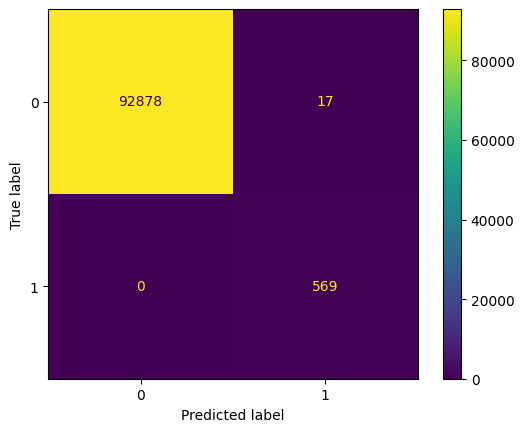

In [29]:
ConfusionMatrixDisplay(confusion_matrix(y_test, preds)).plot()